In [2]:
import matplotlib.pyplot as plt
import numpy as np
import json

In [3]:
results_paths = [
    "distil_agents/3_teach_bc_rand_select/evaluations/deterministic/results.json",
    "distil_agents/3_teach_bc_rand_select/evaluations/stochastic/results.json",
    "distil_agents/3_teach_rl_rand_select/evaluations/deterministic/results.json",
    "distil_agents/3_teach_rl_rand_select/evaluations/stochastic/results.json",
]
reward_infos = []
stages_infos = []
arcade_infos = []
for path in results_paths:
    with open(path) as f:
        results = json.load(f)
        reward_infos.append(results["rewards_infos"])
        stages_infos.append(results["stages_infos"])
        arcade_infos.append(results["arcade_runs_infos"])
all_results = [reward_infos, stages_infos, arcade_infos]

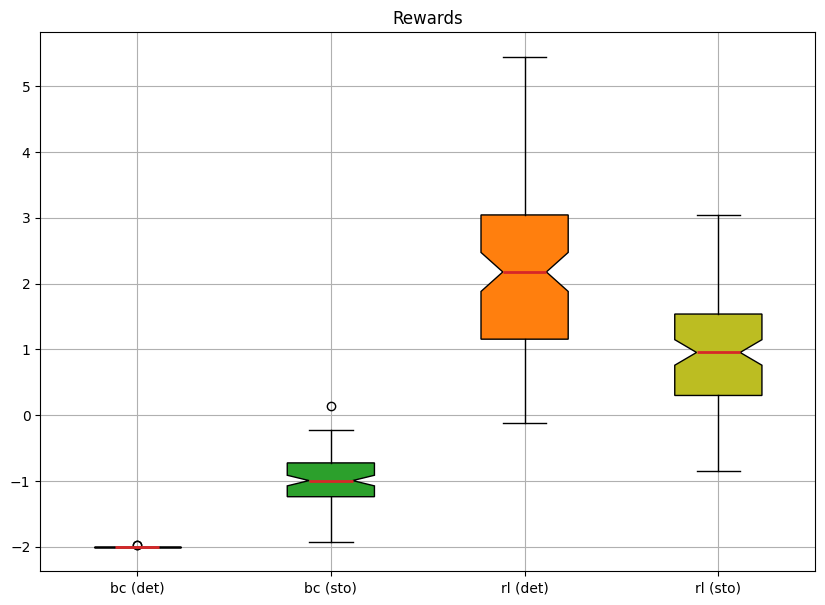

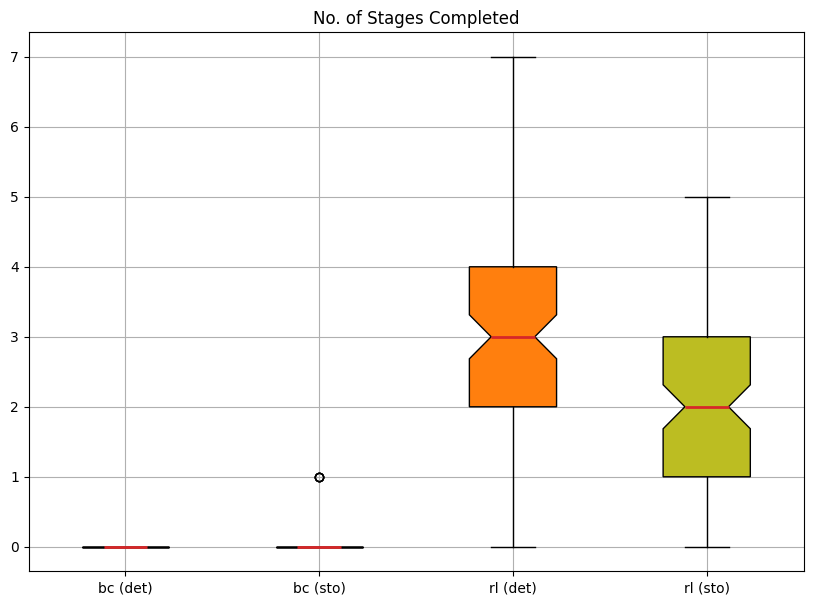

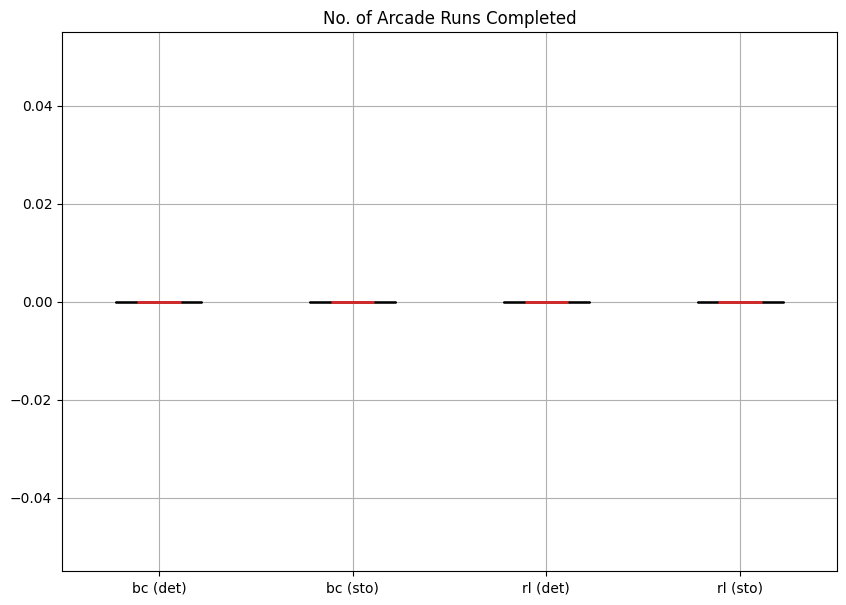

In [4]:
titles = ["Rewards", "No. of Stages Completed", "No. of Arcade Runs Completed"]
colors = ["tab:blue","tab:green","tab:orange","tab:olive","tab:cyan","tab:purple","tab:brown","tab:pink","tab:gray"]
x_tick_labels = [
    "bc (det)",
    "bc (sto)",
    "rl (det)",
    "rl (sto)",
]
for idx, results in enumerate(all_results):
    fig = plt.figure(figsize=(10,7))
    ax = fig.add_subplot(111)
    bp = ax.boxplot(
        results,
        patch_artist=True,
        notch=True,
        vert=0
    )
    for patch, color in zip(bp["boxes"], colors):
        patch.set_facecolor(color)
    for median in bp["medians"]:
        median.set(color="tab:red", linewidth=2)
    ax.set_title(titles[idx])
    ax.set_xticklabels(x_tick_labels)
    ax.grid()
    plt.show()

In [ ]:
results_paths = [
    "final/30_jun_sp_att_def_aa_epsilon/evaluations/evaluation_results/results.json",
    "tests_2/ryu_1p_diff_8/evaluations/evaluation_results/results.json",
    "final/30_jun_sp_att_def_aa/evaluations/diff_6/results.json",
]
teacher_sim_means = []
teacher_sim_stds = []
for path in results_paths:
    with open(path) as f:
        results = json.load(f)
        teacher_sim_means.append(results["teacher_likelihood_means"])
        teacher_sim_stds.append(results["teacher_likelihood_stds"])

for s_idx, means_and_stds in enumerate(zip(teacher_sim_means, teacher_sim_stds)):
    means, stds = means_and_stds
    print("-----------------------------------------------------------------")
    for t_idx, t_info in enumerate(zip(means, stds)):
        print(f"\nAvg likelihood of student {s_idx + 1} picking the same action as teacher {t_idx + 1}:")
        act_means, act_stds = t_info
        for a_idx, a_info in enumerate(zip(act_means, act_stds)):
            act_mean, act_std = a_info
            act_mean = round(act_mean[0] * 100, 3)
            act_std = round(act_std[0] * 100, 3)
            print(f"Action {a_idx}: {act_mean} +/- {act_std}")
    print("\n-----------------------------------------------------------------")

In [6]:
results_paths = [
    "distil_agents/3_teach_bc_rand_select/evaluations/deterministic/results.json",
    "distil_agents/3_teach_bc_rand_select/evaluations/stochastic/results.json",
    "distil_agents/3_teach_rl_rand_select/evaluations/deterministic/results.json",
    "distil_agents/3_teach_rl_rand_select/evaluations/stochastic/results.json",
]
kl_divs = []
kl_means = []
kl_stds = []
for path in results_paths:
    with open(path) as f:
        results = json.load(f)
        kl_divs.append(results["kl_divergences"])
        kl_means.append(results["mean_kl_divs"])
        kl_stds.append(results["std_kl_divs"])

print("----------------------------------------------------------------")
for s_idx, means_and_stds in enumerate(zip(kl_means, kl_stds)):
    means, stds = means_and_stds
    for t_idx, t_info in enumerate(zip(means, stds)):
        t_mean, t_std = t_info
        print(f"KL divergence between student {s_idx + 1} and teacher {t_idx + 1}: {t_mean:.3f} +/- {t_std:.5f}")
    print("----------------------------------------------------------------")

----------------------------------------------------------------
KL divergence between student 1 and teacher 1: 1.388 +/- 0.49272
KL divergence between student 1 and teacher 2: 1.269 +/- 0.50200
KL divergence between student 1 and teacher 3: 2.463 +/- 0.53160
----------------------------------------------------------------
KL divergence between student 2 and teacher 1: 1.310 +/- 0.36320
KL divergence between student 2 and teacher 2: 1.329 +/- 0.36652
KL divergence between student 2 and teacher 3: 2.210 +/- 0.39597
----------------------------------------------------------------
KL divergence between student 3 and teacher 1: 0.853 +/- 0.05314
KL divergence between student 3 and teacher 2: 0.315 +/- 0.01694
KL divergence between student 3 and teacher 3: 2.829 +/- 0.18514
----------------------------------------------------------------
KL divergence between student 4 and teacher 1: 0.852 +/- 0.04138
KL divergence between student 4 and teacher 2: 0.318 +/- 0.01255
KL divergence between stu